<a href="https://colab.research.google.com/github/RSNA/MagiciansCorner/blob/master/Magicians_Corner_9_Performance_Metrics_for_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magicians Corner: 9. Performance Metrics for Machine Learning

###by: Bradley J Erickson, MD PhD and Felipe Kitamura, MD MSc
*Copyright 2020

###See corresponding Radiology: Artificial Intelligence article here: << TBD >>


Thanks to scikit-learn (https://scikit-learn.org/0.20/index.html)


In this tutorial, we'll focus on classification and segmentation metrics

# 1. Classification Metrics

Classification models can be divided into:


1.   **Binary**: the model output is a single decimal number between 0 and 1. After applying a threshold, it will turn into 0 or 1. Example: an X-ray can have consolidation or not.
2.   **Multiclass**: the model output is made of N decimal numbers (N is the number of classes). After applying a threshold, only one of the classes can be 1. The rest will be zero. Example: a modality can only be MR, or CT, or US, or CR. Not more than 1 of them.
3.   **Multilabel**: the model output is made of N decimal numbers (N is the number of classes). After applying a threshold, any of the classes can be 0 or 1. Example: a head CT slice with intracranial hemorrhage can have any combination of epidural, subdural, intraventricular, and/or intraparenchymal hemorrhage.

We'll focus on binary classification.



In [ ]:
# Cell 1

# First, we import the libraries we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, \
                            auc, \
                            precision_recall_curve, \
                            average_precision_score, \
                            roc_auc_score, \
                            confusion_matrix, \
                            accuracy_score, \
                            f1_score, \
                            cohen_kappa_score
from sklearn.utils.multiclass import unique_labels
from sklearn.calibration import calibration_curve
import ipywidgets as widgets
from IPython.display import clear_output

## Binary Classification

Let's supose we have a model that classifies an X-ray image into normal vs pneumonia.

In this case, the model output will be a decimal number somewhere between 0 and 1. As convention, we will define 0 as normal and 1 as pneumonia.

So, what do we do if, for a given X-ray, the model output (score) is 0.5? What if it's 0.3, or 0.9?

The first concept we need to cover is the **threshold**. The **threshold** is a cutoff value above which we say the result is 1. If the score is equal or less than the threshold, the result is 0.

Higher thresholds mean we will be too picky and undercall the diagnosis, but when we do it, we will be more confident.

Lower thresholds mean we will overcall the diagnosis and  ensure that real positive cases are not missed. However lowering the threshold will also result in more real negative cases being called positive.

Let's go through some examples. In this module we will not train any neural network. We've done the inference of a neural network on the test set and the result is in the scores.csv file.


In [ ]:
# Cell 2

# Download the scores.csv file to calculate the metrics from it.

!wget https://raw.githubusercontent.com/kitamura-felipe/MC10-Metrics4ML/master/scores_1.csv -O scores.csv
!wget https://raw.githubusercontent.com/kitamura-felipe/MC10-Metrics4ML/master/scores_multiclass.csv -O scores_multiclass.csv

--2020-09-08 15:38:27--  https://raw.githubusercontent.com/kitamura-felipe/MC10-Metrics4ML/master/scores_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 237930 (232K) [text/plain]
Saving to: ‘scores.csv’

scores.csv          100%[===================>] 232.35K  --.-KB/s    in 0.03s   

2020-09-08 15:38:27 (6.73 MB/s) - ‘scores.csv’ saved [237930/237930]

--2020-09-08 15:38:27--  https://raw.githubusercontent.com/kitamura-felipe/MC10-Metrics4ML/master/scores_multiclass.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763 [text/plain]

In [ ]:
# Cell 3

# Open this scores.csv file and view some of it's content

df = pd.read_csv('scores.csv')

print("Total number of rows (inferences on X-rays): " + str(len(df)))
print("We see the first 10 cases in this table.")

df.head(10)

Total number of rows (inferences on X-rays): 10200
We see the first 10 cases in this table.


,y_pred,y_test
0,0.610878,1
1,0.941457,1
2,0.960143,1
3,0.994573,1
4,0.526911,1
5,0.817536,1
6,0.953124,1
7,0.902271,1
8,0.913781,1
9,0.958907,1


The first column is the index of the X-rays (here we only showed cases 0 to 9).

The **y_pred** column contains the predicted scores from our neural network for each X-ray.

The **y_test** column contains the grount truth for this test set, annotated by a radiologist.

Let's pick up a **threshold** of 0.5 and calculate how many right and wrong cases we have.

In [ ]:
# Cell 4

threshold = 0.5

# How many cases the model said pneumonia (score > threshold) and the ground truth was pneumonia (1)

true_positives = ((df.y_pred > threshold) & (df.y_test == 1)).sum()

# How many cases the model said pneumonia (score > threshold) but the ground truth was normal (0)

false_positives = ((df.y_pred > threshold) & (df.y_test == 0)).sum()

# How many cases the model said normal (score <= threshold) and the ground truth was normal (0)

true_negatives = ((df.y_pred <= threshold) & (df.y_test == 0)).sum()

# How many cases the model said normal (score <= threshold) but the ground truth was pneumonia (1)

false_negatives = ((df.y_pred <= threshold) & (df.y_test == 1)).sum()

# Now let's print these values

print("True positives: " + str(true_positives))
print("False positives: " + str(false_positives))
print("True negatives: " + str(true_negatives))
print("False negatives: " + str(false_negatives))

True positives: 189
False positives: 247
True negatives: 9753
False negatives: 11


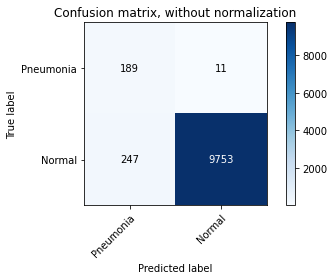

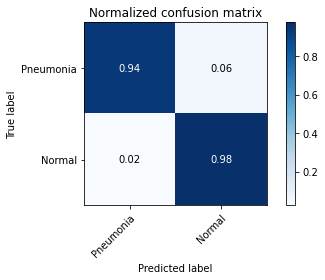

In [ ]:
# Cell 5

# There is a nicer way to see these values. We call it confusion matrix.
# Don't worry about this name. The idea is that it should make things less confusing

# We will plot a 2 x 2 table where the rows represent the ground truth
# and the columns represent the predictions

cm = np.array([[true_positives, false_negatives],
               [false_positives, true_negatives]])


# This is the definition of a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pneumonia', 'Normal'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pneumonia', 'Normal'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

As stated before, the 2x2 tables shown above are confusion matrices.

The first table (without normalization) shows the absolute number of true/false positive/negatives. The second table (normalized) shows relative values to ease interpretation. In this last case, the rows (ground truth) add up to 1.

We can use the cells in the confusion matrix to calculate other metrics:


*   Sensitivity (recall)
*   Specificity
*   False positive rate
*   False negative rate
*   Positive predictive value (precision)
*   Negative predictive value
*   Accuracy
*   F1-score



Let's deep dive into each one of them.

### Sensitivity

$Sensitivity = \frac{True Positives}{True Positives + False Negatives}$

In [ ]:
# Cell 6

# Sensitivity, or recall, or true positive rate is the number of true positives over the total number of real positives (positives by the ground truth)

sensitivity = true_positives / (true_positives + false_negatives)

print("Sensitivity: " + str(sensitivity))

# Sensitivity means: from all positive cases, how many the algorithm was able to spot?

# Sensitivity is dependent on the model performance and is not influenced by prevalence.

# In our pneumonia algorithm, a high sensitivity means our model is able to find almost all pneumonia cases we have in our test set.

# Clinically, we may want a high sensitivity model when the cost of missing a diagnosis is high (no room for undercalling).

Sensitivity: 0.945


### Specificity

$Specificity = \frac{True Negatives}{True Negatives + False Positives}$

In [ ]:
# Cell 7
# Specificity, or selectivity, true negative rate is the number of true negatives over the total number of real negatives (negatives by the ground truth)

specificity = true_negatives / (true_negatives + false_positives)

print("Specificity: " + str(specificity))

# Specificity means: from all negative cases, how many the algorithm was able to spot?

# Specificity is dependent on the model performance and is not influenced by prevalence.

# In our pneumonia algorithm, a high specificity means our model is able to find almost all normal cases we have in our test set.

# Clinically, we may want a high specificity model when the cost of overcalling a diagnosis is high.

Specificity: 0.9753


### False positive rate

$FPR = \frac{False Positives}{True Negatives + False Positives} = 1 - Specificity$

In [ ]:
# Cell 8
# False positive rate, or fall-out, or probability of false alarm is the number of false positives over the total of real negatives.
# It's also related to Type I error (number of overcalls).

fpr = false_positives / (true_negatives + false_positives)

print("False Positive Rate: " + str(fpr)) 

# FPR means: from all negative cases, how many the algorithm was not able to spot?
# FPR is also equivalent to 1 - Specificity

# FPR is dependent on the model performance and is not influenced by prevalence.

# Clinically, we may want a low FPR  model (the same as high specificity) when the cost of overcalling a diagnosis is high.

False Positive Rate: 0.0247


### False negative rate

$FNR = \frac{False Negatives}{True Positives + False Negatives} = 1 - Sensitivity$

In [ ]:
# Cell 9
# False negative rate, or miss rate is the number of false negatives over the total of real negatives.
# It's also related to Type II error (number of undercalls).

fnr = false_negatives / (true_positives + false_negatives)

print("False Negative Rate: " + str(fnr)) 

# FNR means: from all positive cases, how many the algorithm was not able to spot?
# FNR is also equivalent to 1 - Sensitivity

# FNR is dependent on the model performance and is not influenced by prevalence.

# Clinically, we may want a low FNR  model (the same as high sensitivity) when the cost of undercalling a diagnosis is high.

False Negative Rate: 0.055


### Positive predictive value

$PPV = \frac{True Positives}{True Positives + False Positives}$

In [ ]:
# Cell 10
# Positive predictive value, or precision is the number of true positives over the total of cases predicted as positive by the model.

ppv = true_positives / (true_positives + false_positives)

print("Positive Predictive Value: " + str(ppv))    # a.k.a. precision

# PPV or Precision means: from all cases the model predicted positive, how many are really positive?

# Precision is dependent on both the model performance and prevalence

# Clinically, precision may be the most visible metric for a radiologist using an AI system. 
# For each case the model predicts a pneumonia, precision is the probability it is right 

Positive Predictive Value: 0.4334862385321101


### Negative predictive value

$NPV = \frac{True Negatives}{True Negatives + False Negatives}$

In [ ]:
# Cell 11
# Negative predictive value (NPV) is the number of true negatives over the total of cases predicted as negative by the model.

npv = true_negatives / (true_negatives + false_negatives)

print("Negative Predictive Value: " + str(npv))

# Negative predictive value means: from all cases the model predicted negative, how many are really negative?

# Negative predictive value is dependent on both the model performance and prevalence

# Clinically, NPV may also be quite a visible metric for a radiologist using an AI system. 
# For each case the model predicts normal, NPV is the probability it is right 

Negative Predictive Value: 0.9988734125358459


### Accuracy

$Accuracy = \frac{True Positives + True Negatives}{True Positives+False Negatives+True Negatives+FalsePositives}$

In [ ]:
# Cell 12
# Accuracy is the total of correct predictions over the total of cases

accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + true_negatives + false_positives)

print("Accuracy: " + str(accuracy))

# Accuracy means: how many cases did the model predict correctly?

# Accuracy is dependent on both the model performance and prevalence

Accuracy: 0.9747058823529412


**Important note:** accuracy is known to be unrealisticaly high in the case of imbalanced datasets (very low or very high prevalence). Thus, we should not trust in accuracy in these cases. F1-score and other metrics are more reliable in these scenarios.

### F1-score

$F1 = \frac{2True Positives}{2True Positives+FalsePositives+False Negatives} = 2\frac{Precision*Recall}{Precision + Recall} = Dice$

In [ ]:
# Cell 13
# F1-score, or F-score, or F-measure is the harmonic mean of precision and recall (positive predictive value and sensitivity)

f1 = 2 * true_positives / (2 * true_positives + false_positives + false_negatives)

print("F1-score: " + str(f1))

# F1-score is also the same metric as the Dice similarity coefficient (Dice-Sorensen Coefficient).
# In radiology AI examples, we usualy choose the name F1 when we are dealing in the image or study level,
# while Dice is reserved for the pixel level. We'll detail Dice later on this notebook.

# In a low prevalence setting, F1-score is preferred over accuracy.

# F1-score is dependent on both the model performance and prevalence

F1-score: 0.5943396226415094


All the metrics we've covered so far are **dependent** on the **chosen threshold**.

The optimal threshold for one metric is not necessarily the optimal threshold for the other ones.

For this reason, we must choose the metric we want to optimize to find the best threshold for that metric.

Try out different thresholds to understand how it impacts the confusion matrix for our classifier and the metrics shown.


In [ ]:
# Cell 14

# Execute this cell once
# Then updade the slider and click "Calculate" as many times you want.

slider = widgets.IntSlider(value=50, min=0.0, max=100, step=1 )
display(slider)

button = widgets.Button(description="Calculate")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    clear_output()
    threshold = slider.value / 100.
    print("Threshold: " + str(threshold))
    true_positives = ((df.y_pred > threshold) & (df.y_test == 1)).sum()
    false_positives = ((df.y_pred > threshold) & (df.y_test == 0)).sum()
    true_negatives = ((df.y_pred <= threshold) & (df.y_test == 0)).sum()
    false_negatives = ((df.y_pred <= threshold) & (df.y_test == 1)).sum()    
    cm = np.array([[true_positives, false_negatives],
                  [false_positives, true_negatives]])
    
    plot_confusion_matrix(cm, classes=['Pneumonia', 'Normal'], normalize=True,
                      title='Normalized confusion matrix')
    plt.show()

    sensitivity = true_positives / (true_positives + false_negatives)
    print("Sensitivity: " + str(sensitivity))
    specificity = true_negatives / (true_negatives + false_positives)
    print("Specificity: " + str(specificity))    
    precision = true_positives / (true_positives + false_positives)
    print("Precision: " + str(precision)) 
    accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + true_negatives + false_positives)
    print("Accuracy: " + str(accuracy))
    f1 = 2 * true_positives / (2 * true_positives + false_positives + false_negatives)
    print("F1-score: " + str(f1))

button.on_click(on_button_clicked)
display(button, output)


IntSlider(value=50)

Button(description='Calculate', style=ButtonStyle())

Output()

In this next cell, we will plot each metric as a function of the threshold to see how each of them behave.

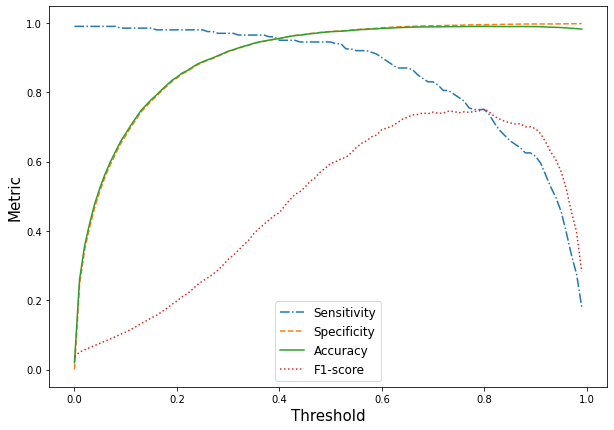

In [ ]:
# Cell 15

tp, tn, fp, fn = [], [], [], []
sens, spec, acc, f1, prec = [], [], [], [], []
th = []

for threshold in range(100):
    threshold/=100
    tp.append( ((df.y_pred > threshold) & (df.y_test == 1)).sum())
    fp.append( ((df.y_pred > threshold) & (df.y_test == 0)).sum())
    tn.append( ((df.y_pred <= threshold) & (df.y_test == 0)).sum())
    fn.append( ((df.y_pred <= threshold) & (df.y_test == 1)).sum())
    sens.append(tp[-1] / (tp[-1] + fn[-1]))
    spec.append(tn[-1] / (tn[-1] + fp[-1]))
    acc.append((tp[-1] + tn[-1]) / (tp[-1] + tn[-1] + fp[-1] + fn[-1]))
    f1.append((2 * tp[-1]) / (2 * tp[-1] + fn[-1] + fp[-1]))
    if (tp[-1] + fp[-1]) == 0:
        prec.append(1e+6)  # avoid divide by 0 error
    else:
        prec.append(tp[-1] / (tp[-1] + fp[-1]))
    th.append(threshold)

sens = np.array(sens)
spec = np.array(spec)
prec = np.array(prec)
th = np.array(th)

plt.figure(figsize=(10,7))
plt.plot(th, sens, ls='-.')
plt.plot(th, spec, ls='--')
plt.plot(th, acc, ls='-')
plt.plot(th, f1, ls=':')
plt.legend(['Sensitivity', 'Specificity', 'Accuracy', 'F1-score'], fontsize=12)
plt.xlabel('Threshold', size=15)
plt.ylabel('Metric', size=15)
plt.show()

As we increase the threshold, sensitivity decreases and specificity increases.

Accuracy and F1-score have optimal values in the middle-range for our model, though the drop in accuracy is small because there are very few cases of pneumonia--even when we call all cases normal, our accuracy remains high.

Of note, the shape of these curves may vary depending on the model and dataset.

There are two other important metrics we haven't covered so far: ROC curve and PR curve, with their respective areas under the curve.

### Receiver Operator Characteristic (ROC) curve


The ROC curve is a plot of the discriminatory ability of a binary test across all threshold range (from 0 to 1).

The **Y axis** is the **Sensitivity**, or true positive rate, and relates to the Power of the model.

The **X axis** is **1 - Specificity**, or the false positive rate, and relates to the Type I error.

The Area Under the ROC Curve (**AUCROC**) is independent of the prevalence and independent of the threshold. It summarizes the discriminatory ability of a model.

If we randomly draw one positive case and one negative case from our testset, the probability that the score of the positive case will be greater than the score of the negative case is the **AUCROC**.

Try out to change the threshold and see that it defines a point in the ROC curve, but it doesn't change the curve itself, nor the area under it.

In [ ]:
# Cell 16

slider = widgets.IntSlider(value=50, min=0.0, max=100, step=1 )
display(slider)

button = widgets.Button(description="Calculate")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    clear_output()
    threshold = slider.value / 100.
    ind = abs(th - threshold).argmin()
    roc_auc = auc(1 - spec, sens)

    plt.figure(figsize=(10, 7))
    lw = 2
    plt.plot(1 - spec, sens, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(1 - spec[ind], sens[ind], 'go--', linewidth=2, markersize=12)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('Receiver operating characteristic curve', size=15)
    plt.legend(loc="lower right")
    plt.show()
    print("Sensitivity, or True Positive Rate, or recall: " + str(sens[ind]))
    print("Specificity, or 1 - False Positive Rate: " + str(spec[ind]))  

button.on_click(on_button_clicked)
display(button, output)

IntSlider(value=50)

Button(description='Calculate', style=ButtonStyle())

Output()

The ROC curve is all about the trade-off between sensitivity and specificity.

Depending on the clinical use-case, sensitivity can be more important than specificity, or vice-versa. 

If both false positive rate and false negative rate are equaly not desired, the **Youden's J statistic** can be used to choose the best operating point in the ROC curve.

The **Youden's J statistic** is defined as **sensitivity + specificity - 1**

### Precision-Recall (PR) curve

As the name suggests, the Precision-Recall curve shows the trade-off between precision (positive predictive value) and recall (sensitivity).

As precision is dependent on the prevalence, the PR curve depends on the prevalence.

Like the area under the ROC curve, the area under the PR curve doesn't depend on the threshold.

However, each threshold defines a point in the PR curve. 

In [ ]:
# Cell 17

slider = widgets.IntSlider(value=50, min=0.0, max=100, step=1 )
display(slider)

button = widgets.Button(description="Calculate")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    clear_output()
    threshold = slider.value / 100.
    ind = abs(th - threshold).argmin()
    roc_auc = average_precision_score( df.y_test, df.y_pred)

    plt.figure(figsize=(10, 7))
    lw = 2
    plt.plot(sens, prec, color='darkorange',
            lw=lw, label='PR curve (area = %0.2f)' % roc_auc )
    plt.plot(sens[ind], prec[ind], 'go--', linewidth=2, markersize=12)
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Recall', size=13)
    plt.ylabel('Precision', size=13)
    plt.title('Precision-Recall curve', size=15)
    plt.legend(loc="lower right")
    plt.show()
    print("Sensitivity, or True Positive Rate, or recall: " + str(sens[ind]))
    print("Precision, or Positive Predictive Value: " + str(prec[ind]))
    print("F1-score: " + str(f1[ind]))  

button.on_click(on_button_clicked)
display(button, output)

IntSlider(value=50)

Button(description='Calculate', style=ButtonStyle())

Output()

### A note on **multiclass and multilabel** classifiers:

Almost all binary classification metrics apply to multiclass and multilabel setting.

However, there are multiple ways of calculating each of the binary metrics as multiclass of multilabel. Let's dive into two main examples:

#### **a. For metrics like recall, precision, accuracy...**

These metrics can be averaged in 4 different ways:
1.   **Micro:** counts the total number of true and false positives and negative, and calculates the metrics globally.
2.   **Macro:** simple mean of the metric calculated separately for each label. Is not influenced by prevalence.
3.   **Weighted:** similar to macro, but the mean is weighted by each respective class frequency.
4.   **Samples:** the metric is calculated for the instance level and then averaged.


In [ ]:
# Cell 18

# In this cell we will demonstrate de difference between F1-score MICRO and F1-score MACRO

# First, we will open this scores_multiclass.csv file and view some of it's content

# This file contains the predictions of a model that classifies an X-ray into 
# normal (class 0), or pneumothorax (class 1) or pneumonia (class 2).

df2 = pd.read_csv('scores_multiclass.csv')

print("Total number of rows (inferences on X-rays): " + str(len(df2)))
print("We see the first 10 cases in this table. \n")

print(df2.head(10))

print("\nClass 0 means normal chest X-ray. We have " + str(len(df2[df2['y_test'] == 0])) + " cases in this class, but only " \
      + str(len(df2[(df2['y_test'] == 0) & (df2['y_pred'] == 0)])) + " of them were predicted as normal.")
print("Class 1 means pneumothorax. We have " + str(len(df2[df2['y_test'] == 1])) + " cases in this class, but only " \
      + str(len(df2[(df2['y_test'] ==1) & (df2['y_pred'] == 1)])) + " of them were predicted as pneumothorax.")
print("Class 2 means pneumonia. We have " + str(len(df2[df2['y_test'] == 2])) + " cases in this class, but only " \
      + str(len(df2[(df2['y_test'] == 2) & (df2['y_pred'] == 2)])) + " of them were predicted as pneumonia. \n")

# Now we calculate F1-micro and F1-macro.

F1_micro = f1_score(df2.y_test, df2.y_pred, average='micro') # average='micro' is where we set the way to calculate
F1_macro = f1_score(df2.y_test, df2.y_pred, average='macro') # average='macro' is where we set the way to calculate


print("F1-micro is " + str(F1_micro))
print("F1-macro is " + str(F1_macro))

Total number of rows (inferences on X-rays): 149
We see the first 10 cases in this table. 

   y_pred  y_test
0       0       0
1       2       2
2       0       1
3       1       1
4       0       2
5       0       0
6       1       0
7       0       0
8       0       0
9       0       0

Class 0 means normal chest X-ray. We have 99 cases in this class, but only 90 of them were predicted as normal.
Class 1 means pneumothorax. We have 10 cases in this class, but only 6 of them were predicted as pneumothorax.
Class 2 means pneumonia. We have 40 cases in this class, but only 28 of them were predicted as pneumonia. 

F1-micro is 0.8322147651006712
F1-macro is 0.7463698993110758


If the **more prevalent classes (normal in our example) are more important**, the we should choose **F1-micro**. If we want to give the **same importance to all classes**, then we should choose **F1-macro**.

In our example, there was a drop in the metric when calculating it as macro. This happened because the less frequent classes (pneumothorax and pneumonia) had worse individual F1-scores. As they are less frequent, they did not impact so much F1-micro. However, as F1-macro gives the same importance to all classes (regardless of class frequency), it shows a bigger drop in performance.

#### **b. For AUCROC**

We must define the way to average as in item a. However, we must also specify the way we calculate AUCROC:


1.   **One-vs-one:** computes the AUCROC for all pairwise combinations of classes and average them.
2.   **One-vs-rest:** computes the AUCROC for each class versus the rest and average them.

In [ ]:
# Cell 19

# Here we calculate AUCROC as "One-vs-rest" with a macro average for
# the same 3-class example we did for F1.

# Multiclass AUCROC calculation need the predictions in the onehot format.
# Onehot representantion is a vector of zeros, with the number 1 in only one 
# position of the vector.

# The onehot encoding for 0 is [1, 0, 0]
# The onehot encoding for 1 is [0, 1, 0]
# The onehot encoding for 2 is [0, 0, 1]

eye = np.identity(3) # This creates an identity matrix of size 3x3
# Each line of this matrix is the onehot representation of the index of that line

onehot_y_pred = [] 

for _pred in df2.y_pred:
    onehot_y_pred.append(eye[_pred]) # Here we recursively map each prediction to it's onehot representation

# Then we use both the ground truth (y_test) and onehot predictions (onehot_y_pred) to calculate the AUCROC

AUCROC_1_vs_rest_macro = roc_auc_score(df2.y_test, onehot_y_pred, multi_class="ovr", average="macro")
# 'ovr' means one-vs-rest. This could be changed to 'ovo' to calculate one-vs-one

print("Multiclass AUCROC One vs rest with macro average: " + str(AUCROC_1_vs_rest_macro))

Multiclass AUCROC One vs rest with macro average: 0.8042113431856683


#### **Additional information: Cohen's Kappa**: this metric is usually used to calculate inter and intra-rater variability for both binary and multiclass problems. It can be calculated in three ways:
1.   **None:** computes kappa with no weights, a good choice for categorical variables.
2.   **Linear:** computes kappa with linear weights, a good choice for ordinal variables.
2.   **Quadratic:** computes kappa with quadratic weights, a good choice for ordinal variables.

In [ ]:
# Cell 20

# Now we will show how to calculate Cohen's Kappa Score for the 
# same 3-class example we did for F1.

kappa = cohen_kappa_score(df2.y_test, df2.y_pred, weights=None)

# To calculate linear or quadratic kappa, replace None with 'linear' or 'quadratic'
# Remember they make more sense in the setting of ordinal variables.

print("Cohen's Kappa Score: " + str(kappa))

Cohen's Kappa Score: 0.6399574714865648


### Calibration curve

The model output can be considered a probability that the case on screen is 1 (pneumonia in our case). However, this probability may not be well calibrated, meaning it could be higher or lower than it should.

To measure how well the output probabilities are calibrated, we will plot a curve that shows the prevalence of 1 (ground truth positive) as a function of the threshold.

We should expect a linear correlation (x=y) in a perfectly calibrated model.

A calibrated model may be required in some circumstances, but not always.

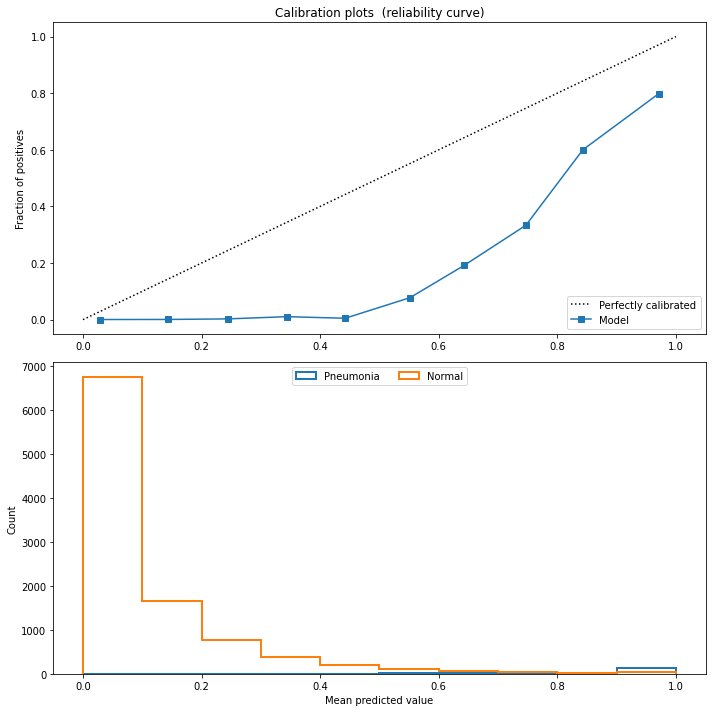

In [ ]:
# Cell 21
# Plot calibration plot

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (2, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for name in [('Model')]:

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(df.y_test, df.y_pred, n_bins=10, strategy='uniform')

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(df.y_pred[df.y_test == 1], range=(0, 1), bins=10, label="Pneumonia",
             histtype="step", lw=2)
    ax2.hist(df.y_pred[df.y_test == 0], range=(0, 1), bins=10, label="Normal",
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [ ]:
df.y_pred

0      0
1      2
2      0
3      1
4      0
      ..
144    2
145    2
146    2
147    2
148    2
Name: y_pred, Length: 149, dtype: int64

The Calibration plot shows that our model is not well calibrated.

The lower part of the plot shows the distribution os scores for the positive (pneumonia) and the negative (normal) classes. It's clear there is a class imbalance (pneumonia cases are less frequent).

# 2. Segmentation Metrics

Segmentation is the denotation of parts of an image as parts of a specific structures--eg to trace the liver in a CT image. This task demands a different metric than what is used for classification. 
A popular metric for segmentation is the Dice-Sorensen Coefficient, which is computed as 
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)
where X is the 'truth' and Y is the 'predicted' segmentation. 

In the deep learning world, we do a slight modification of this, in which we add a small number to the denominator so that in the case where an image has no pixels in the object, and the algorithm correctly also has 0 pixels, we avoid a divide by 0 error. This was described in the prior Magcian's Corner article on segmentation.

In this cell, we again define this modified dice_score, and also a dice_loss, which also is slightly different than a dice score, and which some refer to as a 'soft dice score'.

In [ ]:
# Cell 22

def dice_coeff(y_true, y_pred):
    _epsilon = 10 ** -7
    im1 = np.asarray(y_true).astype(np.bool)
    im2 = np.asarray(y_pred).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() + _epsilon) / (im1.sum() + im2.sum() + _epsilon)

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss



For training purposes, we will not do any segmentation, but will instead use defined images for truth and prediction so that we can easily see the impact of various conditions.
In this case, we will use a function that will have 0's as background and 1's as foreground (object). The user may pass in the img_size, as well as the start and end x and y values. 

In [ ]:
# Cell 23
# Compute Hausdorf, which is the distance/error of one edge to another
# code taken from: https://github.com/sapphire008/Python/blob/master/generic/HausdorffDistance.py

from numpy.core.umath_tests import inner1d

def HausdorffDist(A,B):
    # The Hausdorff distance between A and B, denoted by dH(A,B),
    # is defined by:
    # dH(A,B) = max(h(A,B),h(B,A)),
    # where h(A,B) = max(min(d(a,b))
    # and d(a,b) is a L2 norm
    # dist_H = hausdorff(A,B)
    # See Edward DongBo Cui; Stanford University; 06/17/2014

    # Find pairwise distance
    D_mat = np.sqrt(inner1d(A,A)[np.newaxis].T + inner1d(B,B)-2*(np.dot(A,B.T)))
    # Find DH
    dH = np.max(np.array([np.max(np.min(D_mat,axis=0)),np.max(np.min(D_mat,axis=1))]))
    return(dH)

def ModHausdorffDist(A,B):
    #This function computes the Modified Hausdorff Distance (MHD) which is
    #proven to function better than the directed HD as per Dubuisson et al.
    #in the following work:
    #
    #M. P. Dubuisson and A. K. Jain. A Modified Hausdorff distance for object
    #matching. In ICPR94, pages A:566-568, Jerusalem, Israel, 1994.
    #http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=576361
    #
    #The function computes the forward and reverse distances and outputs the
    #maximum/minimum of both.
    #Optionally, the function can return forward and reverse distance.

    # Find pairwise distance
    D_mat = np.sqrt(inner1d(A,A)[np.newaxis].T + inner1d(B,B)-2*(np.dot(A,B.T)))
    # Calculating the forward HD: mean(min(each col))
    FHD = np.mean(np.min(D_mat,axis=1))
    # Calculating the reverse HD: mean(min(each row))
    RHD = np.mean(np.min(D_mat,axis=0))
    # Calculating mhd
    MHD = np.max(np.array([FHD, RHD]))
    return(MHD, FHD, RHD)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  """


In [ ]:
# Cell #24

def create_img(img_size = 100, start_x=25, start_y=25, end_x=75, end_y=75):
    img = np.zeros((img_size, img_size), dtype = np.int16)
    if start_x < 0:
        start_x = 0
    if start_y < 0:
        start_y = 0
    if end_x > img_size:
        end_x = img_size
    if end_y > img_size:
        end_y = img_size
    img[start_x:end_x + 1, start_y:end_y + 1] = 1
    return img


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images (truth, prediction):
    img = truth * 2 + prediction
    imgplot = plt.imshow(img, interpolation="nearest", cmap="hot")
    return

DSC is 0.8685358255479017, loss is 0.13146417445209835, Hausdorf = 3.1622776601683795, Modified Hausdorf = (1.7076299364909249, 1.6127616066858734, 1.7076299364909249)


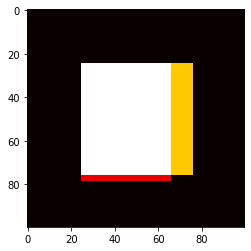

In [ ]:
#Cell #25  Test some of the metrics

SIZE = 100
truth = create_img (img_size = SIZE, start_x=25, start_y = 25, end_x = 75, end_y = 75)
pred = create_img (img_size = SIZE, start_x=25, start_y = 25, end_x = 78, end_y = 65)

dsc = dice_coeff(truth, pred)
loss = dice_loss (truth, pred)
hd = HausdorffDist(truth, pred)
mhd = ModHausdorffDist(truth, pred)
show_images(truth, pred)
print ("DSC is " + str(dsc) + ", loss is " + str(loss) + ", Hausdorf = " + str(hd) + ", Modified Hausdorf = " + str(mhd))


DSC is 1.0, loss is 0.0, Hausdorf = 0.0, Modified Hausdorf = (0.0, 0.0, 0.0)


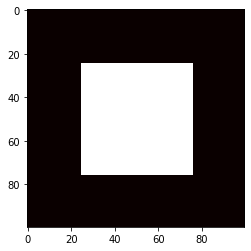

In [ ]:
#Cell #26

# set truth to known values, just in case they get changed
truth[:,:] = 0
truth[25:76, 25:76] = 1

pred[:,:] = 0  # set the prediction back to 0
pred[25:76, 25:76] = 1 # this now matches the truth

# Variation 1--draw a line perpendicular
#pred[76:85, 35:36] = 1
# DSC is 0.9982728842832801, loss is 0.001727115716719907, Hausdorf = 1.0, Modified Hausdorf = (0.09, 0.0, 0.09)

# Variation 2--prediction is offset by 1 pixel
#pred[:,:] = 0.  # set the prediction back to 0
#pred[26:77, 26:77] = 1 # this now matches the truth
# DSC is 0.9611687812387318, loss is 0.03883121876126816, Hausdorf = 1.4142135623730951, Modified Hausdorf = (0.7212489168102786, 0.7212489168102786, 0.7212489168102786)

# Variation 3--same # pixels but rectangular, not square. prediction is still offset by 1 pixel
#truth[:,:] = 0
#truth[10:90, 45:55] = 1
#pred[:,:] = 0.  # set the prediction back to 0
#pred[11:91, 46:56] = 1 # this now matches the truth
# DSC is 0.8887500000069531, loss is 0.11124999999304686, Hausdorf = 1.4142135623730951, Modified Hausdorf = (1.1313708498984765, 1.1313708498984765, 1.1313708498984765)

dsc = dice_coeff(truth, pred)
loss = dice_loss (truth, pred)
hd = HausdorffDist(truth, pred)
mhd = ModHausdorffDist(truth, pred)
show_images(truth, pred)
print ("DSC is " + str(dsc) + ", loss is " + str(loss) + ", Hausdorf = " + str(hd) + ", Modified Hausdorf = " + str(mhd))


We hope you have enjoyed and learned from this notebook.